In [26]:
import pandas as pd

va_building_permits = pd.read_csv('./va_building_permits.csv')
va_housing_prices = pd.read_csv('./va_housing_prices.csv')
va_median_household_income = pd.read_csv('./va_median_household_income.csv')
va_population = pd.read_csv('./va_population.csv')
va_population['VAPOP'] = va_population['VAPOP'] * 1000
va_personal_income = pd.read_csv('./va_personal_income.csv')
va_unemployment_rate = pd.read_csv('./va_unemployment_rate.csv')
va_rental_vacancy_rate = pd.read_csv('./va_rental_vacancy_rate.csv')


In [16]:
# Convert DATE columns to datetime format
datasets = [va_building_permits, va_housing_prices, va_median_household_income,
            va_personal_income, va_population, va_unemployment_rate, va_rental_vacancy_rate]

for df in datasets:
    df['DATE'] = pd.to_datetime(df['DATE'])

# Resample yearly data to monthly by forward-filling
for df in [va_median_household_income, va_personal_income, va_population]:
    df.set_index('DATE', inplace=True)
    df = df.resample('M').ffill().reset_index()

# Begin merging with va_building_permits as the base
merged_df = va_building_permits

# Merge each dataset on the DATE column, including the new population dataset
for df in [va_housing_prices, va_median_household_income, va_personal_income,
           va_population, va_unemployment_rate, va_rental_vacancy_rate]:
    merged_df = pd.merge(merged_df, df, on='DATE', how='outer')

# Rename columns to descriptive names
merged_df.rename(columns={
    'DATE': 'Date',
    'VABPPRIV': 'Building Permits',
    'VAUCSFRCONDOSMSAMID': 'Housing Price Index',
    'MEHOINUSVAA646N': 'Median Household Income',
    'VAPCPI': 'Personal Income Per Capita',
    'VARVAC': 'Rental Vacancy Rate',
    'VAUR': 'Unemployment Rate',
    'VAPOP': 'Population'
}, inplace=True)

# Fill remaining NaNs by using the yearly average for each column
merged_df['Year'] = merged_df['Date'].dt.year
for column in merged_df.columns.drop(['Date', 'Year']):
    merged_df[column] = merged_df.groupby('Year')[column].transform(lambda x: x.fillna(x.mean()))

# Drop the Year column used for grouping
merged_df.drop(columns=['Year'], inplace=True)
merged_df.dropna(inplace=True)

<ipython-input-16-332b39f8dbfc>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').ffill().reset_index()
<ipython-input-16-332b39f8dbfc>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').ffill().reset_index()
<ipython-input-16-332b39f8dbfc>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').ffill().reset_index()


In [27]:
merged_df['Building Permits'] = merged_df['Building Permits'].round(0).astype(int)
merged_df['Housing Price Index'] = merged_df['Housing Price Index'].round(2)
merged_df['Building Permits'] = merged_df['Building Permits'].round(0)
merged_df['Median Household Income'] = merged_df['Median Household Income'].round(0).astype(int)
merged_df['Personal Income Per Capita'] = merged_df['Personal Income Per Capita'].round(0).astype(int)
merged_df['Population'] = merged_df['Population'].round(0).astype(int)
merged_df['Unemployment Rate'] = merged_df['Unemployment Rate'].round(1)
merged_df['Rental Vacancy Rate'] = merged_df['Rental Vacancy Rate'].round(1)

merged_df.to_csv('./va_housing_market_monthly_aggregated.csv', index=False)

In [28]:
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('./va_housing_market_monthly_aggregated.csv')
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf


# Set the target variable (e.g., 'Housing Price Index') and features
target = 'Housing Price Index'
features = data.columns.drop(['Date', target])

X = data[features]
y = data[target]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
print("Linear Regression")
print("MSE:", mean_squared_error(y_test, y_pred_lin))
print("R^2 Score:", r2_score(y_test, y_pred_lin))

Linear Regression
MSE: 0.1037153850308602
R^2 Score: 0.8860678860271212


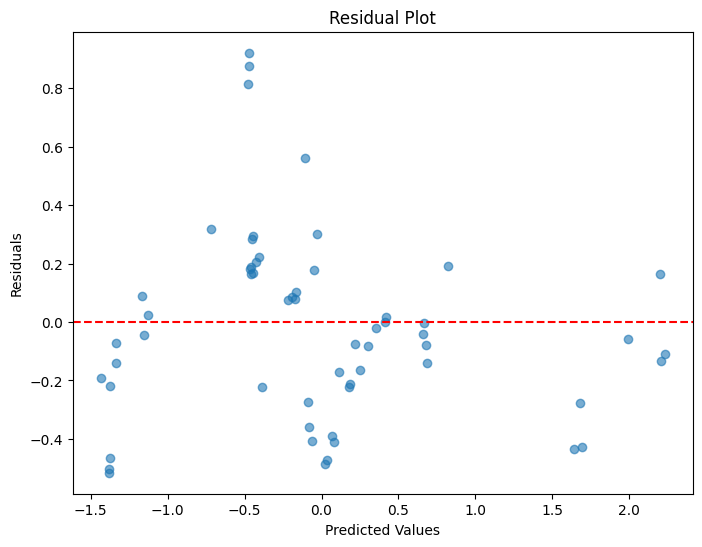

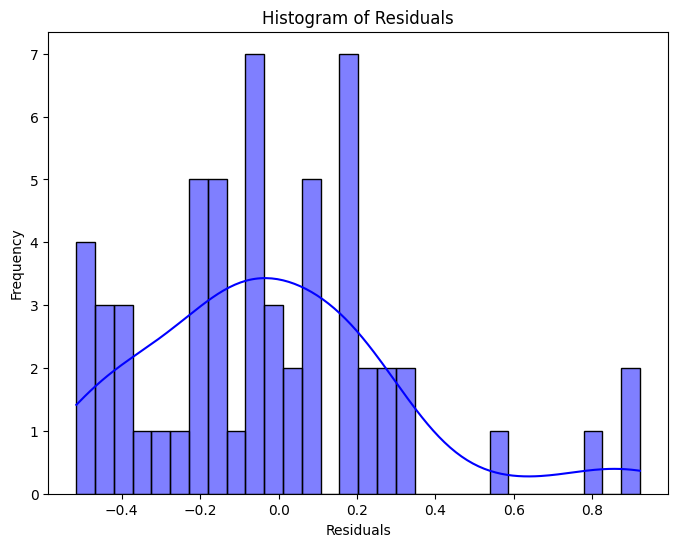

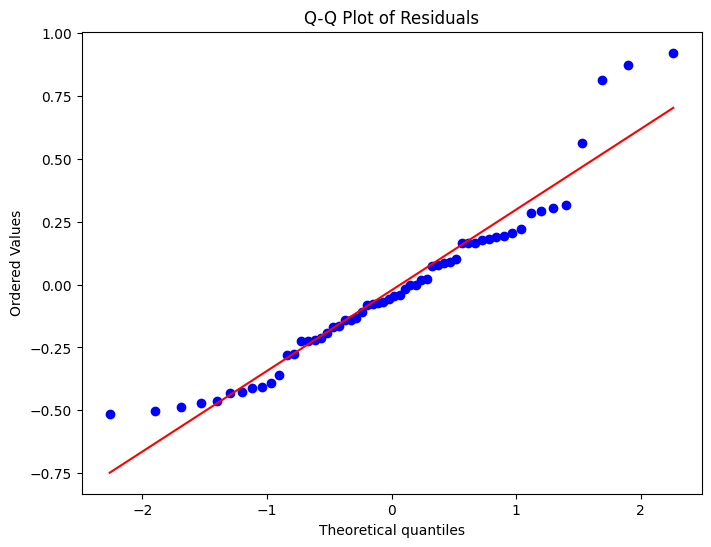

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

residuals = y_test - y_pred_lin

# Residual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lin, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

Residual plot suggests linear model might not fully capture relationships

In [32]:
import numpy as np

log_data = pd.read_csv('./va_housing_market_monthly_aggregated.csv')
X_log = log_data[features]
y_log = np.log(log_data[target])

In [37]:
# 2. Exponential Regression
'''
We want to fit our data to model : y = a * exp(b * x)
We use linear regression, equivalently fit data to model : ln(y) = ln(a) + bx
'''
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

exp_reg = LinearRegression()
exp_reg.fit(X_train_log, y_train_log)
y_pred_exp = exp_reg.predict(X_test_log)
print("Exponential Regression")
print("MSE:", mean_squared_error(y_test_log, y_pred_exp))
print("R^2 Score:", r2_score(y_test_log, y_pred_exp))


Exponential Regression
MSE: 0.009166773617913657
R^2 Score: 0.8542545697358965


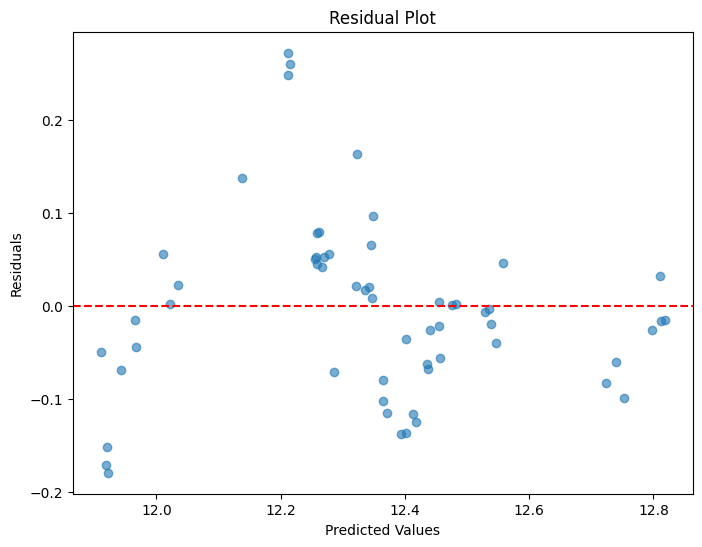

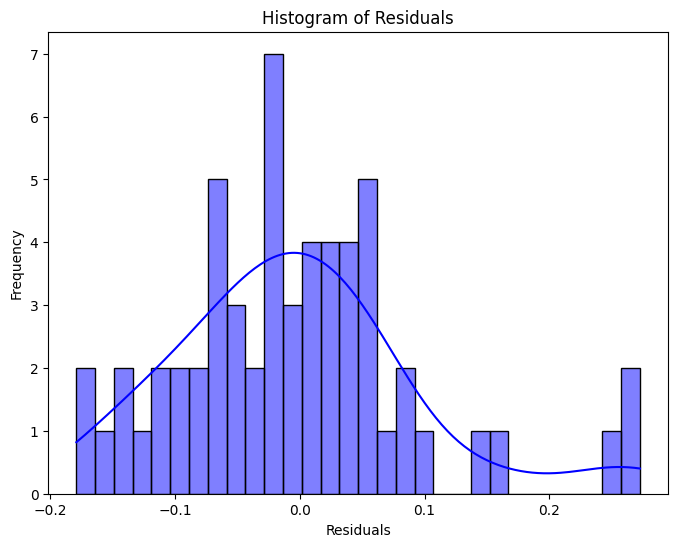

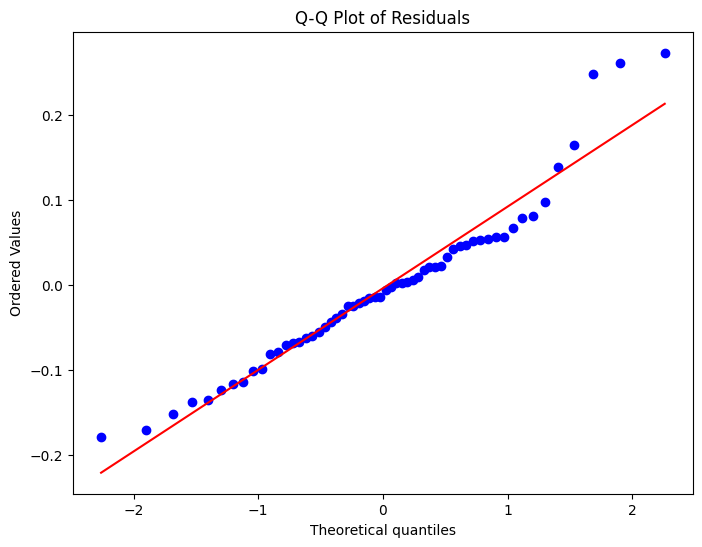

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

exp_residuals = y_test_log - y_pred_exp

# Residual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_exp, exp_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(exp_residuals, kde=True, bins=30, color='blue')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(exp_residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

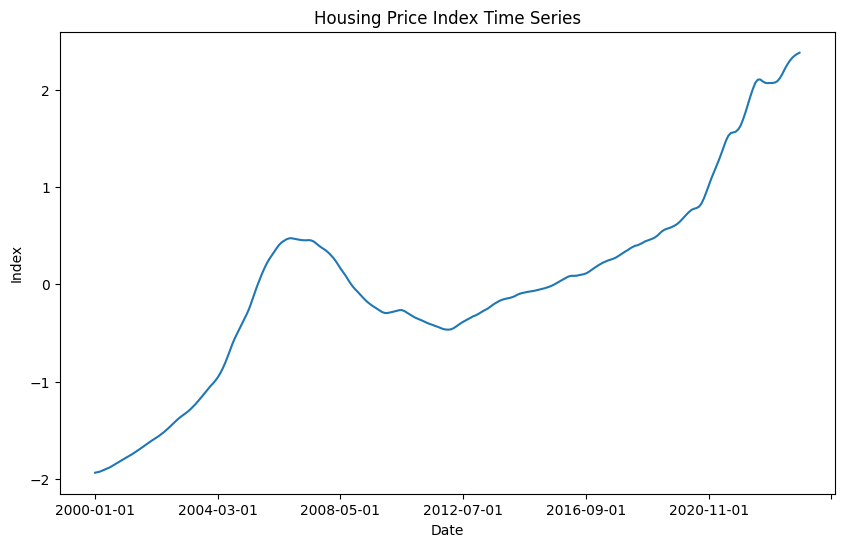

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information 

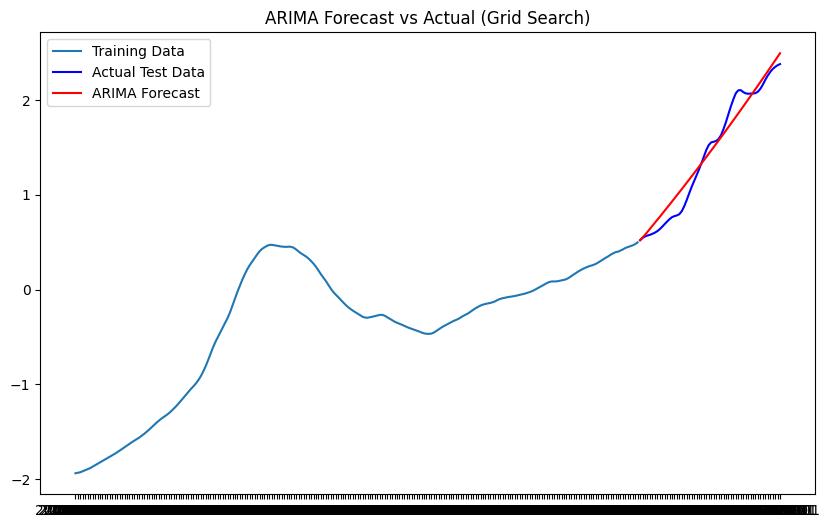

Best ARIMA parameters: (3, 3, 7) with MSE: 0.015017322022214728
Optimized ARIMA Model Mean Squared Error (Grid Search): 0.015017322022214728


In [39]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Ensure the 'Housing Price Index' is a univariate time series
housing_price_index = data.set_index('Date')['Housing Price Index']

# Plot the time series
plt.figure(figsize=(10, 6))
housing_price_index.plot(title='Housing Price Index Time Series', xlabel='Date', ylabel='Index')
plt.show()

# Split into training and test sets (80/20 split)
train_size = int(len(housing_price_index) * 0.8)
train, test = housing_price_index[:train_size], housing_price_index[train_size:]

import itertools

# Define parameter ranges
p_values = range(0, 10)  # Try values for p
d_values = range(0, 10)  # Try values for d
q_values = range(0, 10)  # Try values for q

# Grid search for the best combination
best_score, best_cfg = float("inf"), None
for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        mse = mean_squared_error(test, forecast)
        if mse < best_score:
            best_score, best_cfg = mse, (p, d, q)
    except:
        continue


# Fit the model with the best parameters
p, d, q = best_cfg
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# Forecast the test set
forecast = model_fit.forecast(steps=len(test))
forecast_index = test.index

# Plot the forecast vs actual values
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Test Data', color='blue')
plt.plot(forecast_index, forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs Actual (Grid Search)')
plt.legend()
plt.show()

# Evaluate the optimized model
mse = mean_squared_error(test, forecast)
print(f"Best ARIMA parameters: {best_cfg} with MSE: {best_score}")
print("Optimized ARIMA Model Mean Squared Error (Grid Search):", mse)